# Прогнозирование оттока клиентов

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).  


Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**


Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

**Описание полей данных**


- `BeginDate` – дата начала пользования услугами.
- `EndDate` – дата окончания пользования услугами.
- `Type` – тип оплаты: ежемесячный, годовой и тд.
- `PaperlessBilling` – безналичный расчет.
- `PaymentMethod` – способ оплаты.
- `MonthlyCharges` – ежемесячные траты на услуги.
- `TotalCharges` – всего потрачено денег на услуги.
- `Dependents` – наличие иждивенцев.
- `Senior Citizen` – наличие пенсионного статуса по возрасту.
- `Partner` – наличие супруга(и).
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.


Во всех файлах столбец `customerID` содержит код клиента.


Информация о договорах актуальна на 1 февраля 2020.

## План работы


1. Загрузить, просмотреть, предварительно изучить полученные данные. Оставить комментарии, сделать вывод.
2. Провести предобработку и исследовательский анализ данных. Выделить/создать целевой признак. Оставить комментарии, сделать вывод.
3. Подготовить признаки. Добавить новые признаки. Разделить итоговый датасет на тренировочную и тестовую выборки. Оставить комментарии, сделать вывод.
4. Определить модели, подходящие для исследования, провести подбор гиперпараметров, выделить важные фичи. Оставить комментарии, сделать вывод.
5. Сравнить модели и оценить их эффективность на тестовой выборке. Оставить комментарии, сделать вывод.
6. Провести анализ важности факторов лучшей модели.
7. Сделать общий вывод.


## Загрузка, просмотр, изучение данных

Импорт библиотек:

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve

Запишем данные в соответствующие датафреймы:

In [2]:
df_contract = pd.read_csv(r'D:\final_provider\contract.csv') 
df_internet = pd.read_csv(r'D:\final_provider\internet.csv')
df_personal = pd.read_csv(r'D:\final_provider\personal.csv') 
df_phone = pd.read_csv(r'D:\final_provider\phone.csv') 

Выполним первый взгляд на данные в каждом датафрейме по отдельности.

### Датафрейм с информацией о договорах (df_contract)

Выведем первые 5 строк:

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Основную информацию о датафрейме:

In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.duplicated().sum()

0

Явных пропусков и дубликатов нет, необходима замена типов данных. Посмотрим, какие значения принимают некоторые поля:

In [6]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [7]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [8]:
df_contract['MonthlyCharges'].value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: MonthlyCharges, Length: 1585, dtype: int64

In [9]:
df_contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

В поле `TotalCharges` есть неявные пропуски с пустым значением. Отсюда и неверный тип данных, прежде чем изменять тип заменим пропуски на нули.

Пробежимся по полям датафрейма:

- `customerID` – содержит уникальный айди клиента, никаких действий не требуется;
- `BeginDate` – дата начала пользования услугами, **поле необходимо привести к типу *datetime***;
- `EndDate` – дата окончания пользования услугами. Это наш целевой признак, любая дата в этом поле соответствует оттоку клиента, если стоит значение "No" - клиент остался. Однако, сама по себе дата несет в себе важную ифнормацию - длительность пользования клиентом услугами компании. Отсюда можно сгенерировать дополнительный признак для модели. **Для значения "No" можно установить уникальную дату (например дату актуальности датасета - *2020-02-01*), после чего привести поле к формату datetime**;
- `Type` – тип оплаты, принимает три значения: ежемесячный, годовой, двухгодовой. Никаких действий не требуется; 
- `PaperlessBilling` – безналичный расчет, является бинарным признаком. Никаких действий не требуется;
- `PaymentMethod` - способ оплаты, принимает четыре значения: электронный чек, почтовый чек, банковский перевод и кредитная карта. Никаких действий не требуется; 
- `MonthlyCharges` - ежемесячные траты на услуги, **можно привести поле к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях)**;
- `TotalCharges` - всего потрачено денег на услуги, **необходимо привести к числовому формату и заполнить неявные пропуски нулями**.

### Датафрейм с информацией об интернет-услугах (df_internet)

Выведем первые 5 строк:

In [10]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Основную информацию о датафрейме:

In [11]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
df_internet.duplicated().sum()

0

Явных пропусков и дубликатов нет. Посмотрим, какие значения принимают некоторые поля:

In [13]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Все поля, кроме уникального индификатора пользователя (`customerID`) являются бинарными признаками. Никаких действий не требуется. 

### Датафрейм с персональными данными клиентов (df_personal)

Выведем первые 5 строк:

In [14]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Основную информацию о датафрейме:

In [15]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
df_personal.duplicated().sum()

0

Явных пропусков и дубликатов нет. 

Все поля, кроме уникального индификатора пользователя (`customerID`) также являются бинарными признаками. Никаких действий не требуется. 

### Датафрейм с данными о телефонии (df_phone)

Выведем первые 5 строк:

In [17]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Основную информацию о датафрейме:

In [18]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
df_phone.duplicated().sum()

0

Явных пропусков и дубликатов нет. Датафрейм содержит уникальный индификатор пользователя и бинарный признак `MultipleLines` - наличие возможности ведения параллельных линий во время звонка. Никаких действий не требуется.

### Вывод

1. Загружены и рассмотрены таблицы с данными: 

- `df_contract`;  
- `df_internet`;
- `df_personal`;
- `df_phone`.

2. Всего в выборке представлены договоры с 7043 клиентами, из которых пользователей интернета - 5517, пользователей телефона - 6361.

3. Явные пропуски и дубликаты не найдены.

4. Проблемы для предобработки данных:

- `BeginDate` – поле необходимо привести к типу *datetime*;

- `EndDate` – это наш целевой признак, любая дата в этом поле соответствует оттоку клиента, если стоит значение "No" - клиент остался. Однако, сама по себе дата несет в себе важную ифнормацию - длительность пользования клиентом услугами компании. Отсюда можно сгенерировать дополнительный признак для модели. Для значения "No" можно установить уникальную дату (например дату актуальности датасета - *2020-02-01*), после чего привести поле к формату *datetime*;
- `MonthlyCharges` - можно привести поле к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях);
- `TotalCharges` - необходимо избавится от неявных пропусков (пустые значения, заполним нулями), а также привести к числовому формату, например целочисленный тип.

5. После этого следует объединить все данные в одну таблицу, провести исследовательский анализ данных, а также дополнительное исследование на наличие пропусков и аномалий. 

Дополнительных вопросов к данным на данном этапе не возникло.

## Предобработка и исследовательский анализ данных

Сперва решим выявленные проблемы. Поставим "заглушку" в поле `EndDate` (дату актуальности датасета - *2020-02-01*):

In [20]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])

Заполним неявные пропуски в поле `TotalCharges` нулями:

In [21]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)

Приведем поля `BeginDate` и `EndDate` к типу *datetime*, а `MonthlyCharges` и `TotalCharges` к целочисленному (*int*):

*Примечание.* Так как строковое значение с точкой невозможно сразу преобразовать в целочисленный тип, поле `TotalCharges` сначала приводится в вещественный (*float*), и потом в целый (*int*).

In [22]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format = '%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format = '%Y-%m-%d')

df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype('int')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [23]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('int')

Предобработка завершена. Выполним объединение данных в одну таблицу:

In [24]:
df_telecom = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))
df_telecom = df_telecom.join(df_personal.set_index('customerID'))
df_telecom = df_telecom.join(df_internet.set_index('customerID'))

In [25]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

В полях, соответствующих услугам возникли пропуски - заполним их значением соответствующим "No". Однако, со строковыми признаками неудобно работать. Закодируем все бинарные признаки (начнем с услуг):

In [26]:
def coding_for_binary_features(df, column):
    df[column].fillna(0, inplace = True) # пропуск соответствует значению "No"
    df[column] = df[column].replace(['No'], 0)
    df[column] = df[column].replace(['Yes'], 1)
    return df[column]

In [27]:
df_telecom['MultipleLines'] = coding_for_binary_features(df_telecom, 'MultipleLines')
df_telecom['InternetService'] = coding_for_binary_features(df_telecom, 'InternetService')
df_telecom['OnlineSecurity'] = coding_for_binary_features(df_telecom, 'OnlineSecurity')
df_telecom['OnlineBackup'] = coding_for_binary_features(df_telecom, 'OnlineBackup')
df_telecom['DeviceProtection'] = coding_for_binary_features(df_telecom, 'DeviceProtection')
df_telecom['TechSupport'] = coding_for_binary_features(df_telecom, 'TechSupport')
df_telecom['StreamingTV'] = coding_for_binary_features(df_telecom, 'StreamingTV')
df_telecom['StreamingMovies'] = coding_for_binary_features(df_telecom, 'StreamingMovies')

# отдельно закодируем Partner и Dependents

df_telecom['Partner'] = coding_for_binary_features(df_telecom, 'Partner')
df_telecom['Dependents'] = coding_for_binary_features(df_telecom, 'Dependents')

Бинарными являются также поля `gener`, `Paperless_billing`, `InternetService`:

In [28]:
df_telecom['is_male'] = df_telecom['gender'].replace(['Male'], 1).replace(['Female'], 0)
df_telecom['PaperlessBilling'] = df_telecom['PaperlessBilling'].replace(['Yes'], 1).replace(['No'], 0)
df_telecom['is_DSL_service'] = df_telecom['InternetService'].replace(['DSL'], 1).replace(['Fiber optic'], 0)

Поля `gender` и `InternetService` были трансформированы в `is_male` и `is_DSL_service`, неактуальные отбросим:

In [29]:
df_telecom = df_telecom.drop(['gender', 'InternetService'], axis=1)

Выведем первые 5 строк нового датафрейма:

In [30]:
df_telecom.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_male,is_DSL_service
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29,29,0,0,1,0,0,1,0,0,0,0,0,1
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56,1889,0,0,0,0,1,0,1,0,0,0,1,1
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53,108,0,0,0,0,1,1,0,0,0,0,1,1
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42,1840,0,0,0,0,1,0,1,1,0,0,1,1
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70,151,0,0,0,0,0,0,0,0,0,0,0,0


Посмотрим основную информацию о новом датафрейме:

In [31]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  OnlineSecurity    7043 non-null   int64         
 12  OnlineBackup      7043 non-null   int64         
 13  DeviceProtection  7043 non-null   int64         
 14  TechSupport   

И его основные статистические характеристики:

In [32]:
df_telecom.describe().T

,count,mean,std,min,25%,50%,75%,max
PaperlessBilling,7043.0,0.592219,0.491457,0.0,0.0,1.0,1.0,1.0
MonthlyCharges,7043.0,64.295897,30.092727,18.0,35.0,70.0,89.0,118.0
TotalCharges,7043.0,2279.265086,2266.790864,0.0,398.0,1394.0,3786.5,8684.0
MultipleLines,7043.0,0.421837,0.493888,0.0,0.0,0.0,1.0,1.0
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043.0,0.483033,0.499748,0.0,0.0,0.0,1.0,1.0
Dependents,7043.0,0.299588,0.458110,0.0,0.0,0.0,1.0,1.0
OnlineSecurity,7043.0,0.286668,0.452237,0.0,0.0,0.0,1.0,1.0
OnlineBackup,7043.0,0.344881,0.475363,0.0,0.0,0.0,1.0,1.0
DeviceProtection,7043.0,0.343888,0.475038,0.0,0.0,0.0,1.0,1.0


Из статистических характеристик датафрейма можно выделить интересные особенности:

- практически две трети пользователей предпочитают безналичный расчет;

- среднее значение месячных трат практически совпадает с медианным значением, то есть имеет распределение с небольшим отрицательным смещением;

- **распределение значений суммарных трат наоборот, сильное положительное смещение - медиана практически на 40% меньше среднего. Возможно это связано с наличием нулей - неявных пропусков. Это нужно выяснить далее**;

- относительно демографии: 16% пенсионеров, 48% имеют супруга(у), у 29% клиентов имеются иждевенцы. Баланс классов гендера соблюдается;

- 34% пользователей продолжают использовать интернет соединение через через телефонную линию, 42% пользователей имеют возможность использовать вторую линию во время звонка; 

- По услугам данные приведены в таблице:

|Услуга| Доля пользователей услуги |  
|------|---------------------------|
|антивирус (DeviceProtection)| 34%|
|блокировка небезопасных сайтов (OnlineSecurity)| 29%|
|выделенная линия технической поддержки (TechSupport)| 29%|
|облачное хранилище файлов для резервного копирования данных (OnlineBackup)|34%|
|cтриминговое телевидение (StreamingTV)|38%|
|каталог фильмов (StreamingMovies)|39%|

Посмотрим распределение значений в полях с тратами:

In [33]:
# здесь и далее выставим размер всех графиков
plt.rcParams["figure.figsize"] = (20,8)
# и темный фон с сеткой в seaborn
sns.set_style("darkgrid")

Построим распределение значений ежемесячных трат:

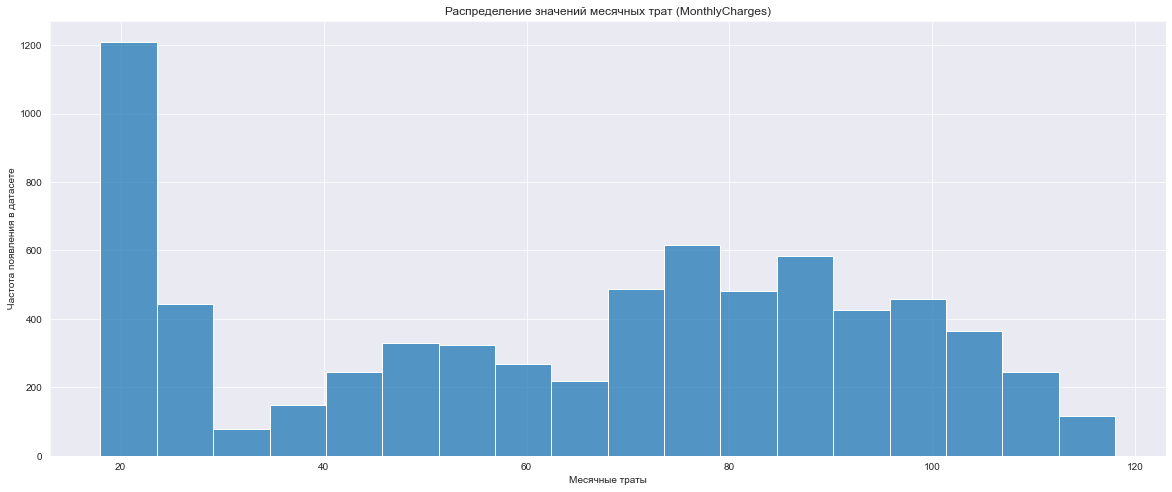

In [34]:
sns.histplot(df_telecom['MonthlyCharges'])
plt.title('Распределение значений месячных трат (MonthlyCharges)')
plt.xlabel('Месячные траты')
plt.ylabel('Частота появления в датасете');

По распределению значений месячных трат выделяются три основные группы клиентов:

- с месячными тратами со значениями 20-30;
- с месячными тратами со значениями 30-70;
- с месячными тратами со значениями 70-120.

Проведем группировку:

In [35]:
df_telecom['MonthlyChargesGroup'] = pd.qcut(df_telecom['MonthlyCharges'], 3, labels=[0, 1, 2])

In [36]:
df_telecom['MonthlyChargesGroup'].value_counts(normalize=True)

0    0.342326
2    0.333097
1    0.324578
Name: MonthlyChargesGroup, dtype: float64

В каждой из групп практически равная доля клиентов.

Выделим целевой признак:

In [37]:
df_telecom['escape_client'] = (df_telecom['EndDate'] != "2020-02-01") * 1

Проверим баланс классов целевого признака:

In [38]:
df_telecom['escape_client'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: escape_client, dtype: float64

Наблюдается дисбаланс классов целевого признака. Займемся этим вопросом позже.

Интересно также посмотреть как будут меняться статистиечские характеристики в созданных группах.

Запишем срез по каждой группе в соответствующий датафрейм:

In [39]:
df_group_0 = df_telecom.query('MonthlyChargesGroup == 0')
df_group_1 = df_telecom.query('MonthlyChargesGroup == 1')
df_group_2 = df_telecom.query('MonthlyChargesGroup == 2')

Так как большенство признаков бинарные, нас интересует только среднее. Запишем среднее по каждой группе в датафрейм-сводник:

In [40]:
stats_pivot_on_groups = pd.DataFrame()
stats_pivot_on_groups['group_0'] = df_group_0.describe().T['mean']
stats_pivot_on_groups['group_1'] = df_group_1.describe().T['mean']
stats_pivot_on_groups['group_2'] = df_group_2.describe().T['mean']

Посмотрим датафрейм:

In [41]:
stats_pivot_on_groups

,group_0,group_1,group_2
PaperlessBilling,0.388221,0.628609,0.766411
MonthlyCharges,28.085856,69.052056,96.874680
TotalCharges,721.800912,1979.614173,4171.868713
MultipleLines,0.156781,0.371391,0.743393
SeniorCitizen,0.070095,0.163605,0.255328
Partner,0.431771,0.451444,0.566496
Dependents,0.359187,0.281277,0.256181
OnlineSecurity,0.098714,0.388889,0.380222
OnlineBackup,0.090419,0.391076,0.561381
DeviceProtection,0.081294,0.362205,0.595908


Из таблицы видно, что клиенты третей группы больше пользуются услугами. Первая группа практически вообще не пользуется дополнительными услугами (доля не превшает 10%)

Примечательно, что:

- доля пользователей, использующих безналичный расчет растет от 38% в первой группе, до 62% во второй группе, и до 76% в третьей группе;

- среди третьей группы больше пенсионеров (7% первая группа, 16% - вторая группа, 25% - третья группа);

- в третей группе больше клиентов, состоящих в браке (43% первая группа, 45% - вторая группа, 57% - третья группа);

- иждевенцев, наоборот, больше в первой группе - 36%, во второй группе 28%, в третьей 26%;

- среди третьей группы только 7% пользователей продолжают использовать интернет соединение через через телефонную линию, во второй группе это значение вырастает до 59%, в третьей 38%;

- отток клиентов самый большой в третьей группе - 34%, во второй группе 29%, в первой 16%.

Построим распределение значений суммарных трат:

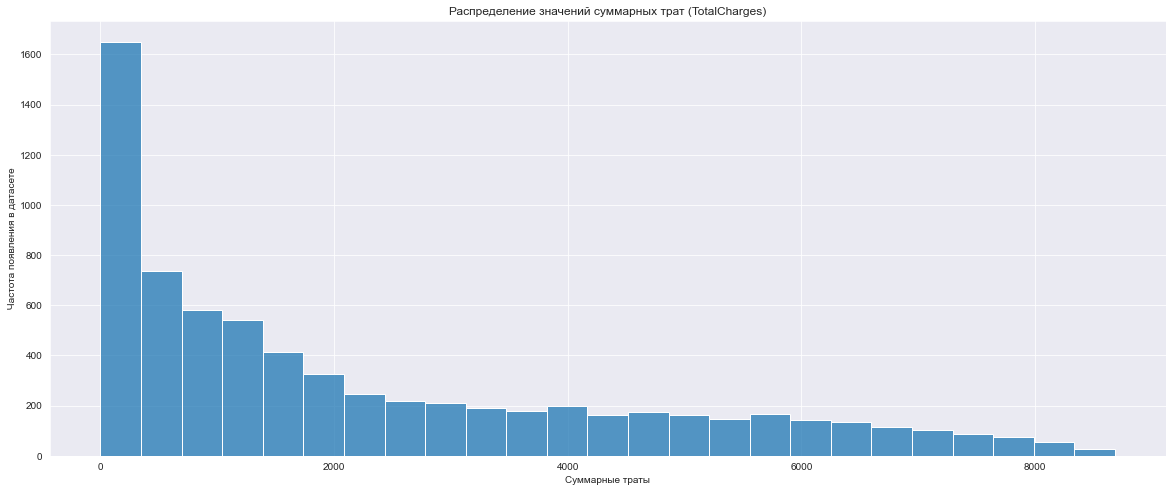

In [42]:
sns.histplot(df_telecom['TotalCharges'])
plt.title('Распределение значений суммарных трат (TotalCharges)')
plt.xlabel('Суммарные траты')
plt.ylabel('Частота появления в датасете');

Распределение суммарных трат напоминает логнормальное распределение. Там есть неявные пропуски, попробуем выяснить их природу:

In [43]:
df_telecom.query('TotalCharges == 0')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_male,is_DSL_service,MonthlyChargesGroup,escape_client
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52,0,0,0,1,...,1,0,1,1,1,0,0,1,1,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80,0,0,0,1,...,1,1,1,0,1,1,0,1,1,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56,0,0,0,1,...,1,1,1,1,1,0,0,1,1,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Это клиенты, начавшие пользоваться услугами в феврале 2020 года, в этом случае суммарные траты равны месячным (дата актуальности датасета - *2020-02-01*):

In [44]:
df_telecom.loc[df_telecom['TotalCharges'] == 0, 'TotalCharges'] = df_telecom['MonthlyCharges']

Так как неявных пропусков было достаточно мало, искать изменения распределения значений бессмысленно, поэтому строить его еще раз не будем.

Изучим подробнее дату регистрации клиентов:

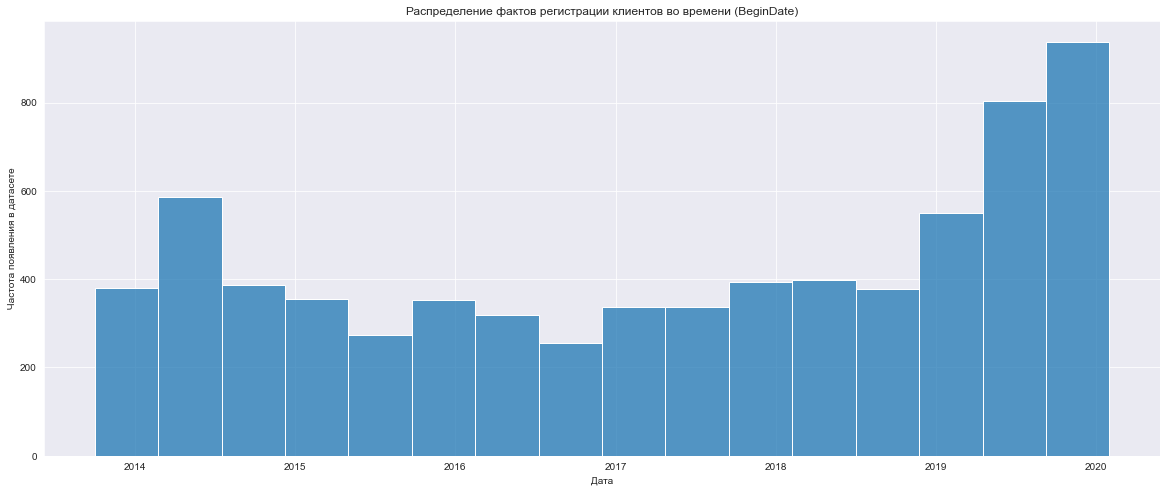

In [45]:
sns.histplot(df_telecom['BeginDate'])
plt.title('Распределение фактов регистрации клиентов во времени (BeginDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина вновь привлеченных клиентов стабильна. Далее с начала 2019 по начало 2020 года снова наблюдаем бурный рост количества новых клиентов.

Посмотрим распределение оттока клиентов во времени:

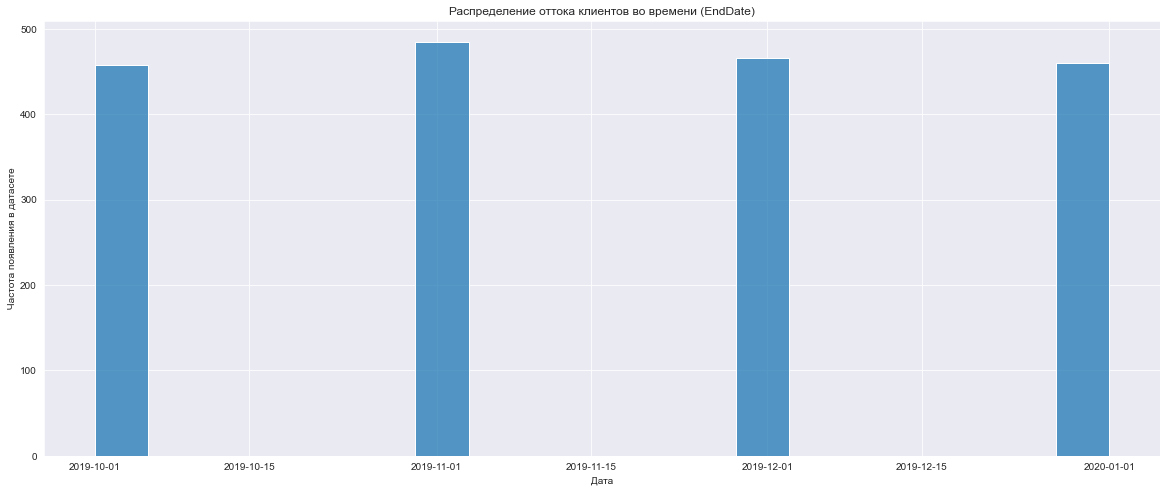

In [46]:
sns.histplot(df_telecom.query('EndDate != "2020-02-01"')['EndDate'])
plt.title('Распределение оттока клиентов во времени (EndDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Примечательно, что дни оттока выглядят достаточно дискретными. Посмотрим уникальные значения поля:

In [47]:
df_telecom.query('EndDate != "2020-02-01"')['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

Только в эти четыре дня происходил отток клиентов, причем распределение практически равномерное. Так как это первое число каждого месяца с октября 2019 по январь 2020, можно предположить что если договор расторгается, то его окончание начинается со следующего отчетного месяца.

Таким образом на протяжении 4 месяцев подряд происходил равномерный отток клиентов.

Посмотрим как распредлены месячные траты оттекших и всех клиентов:

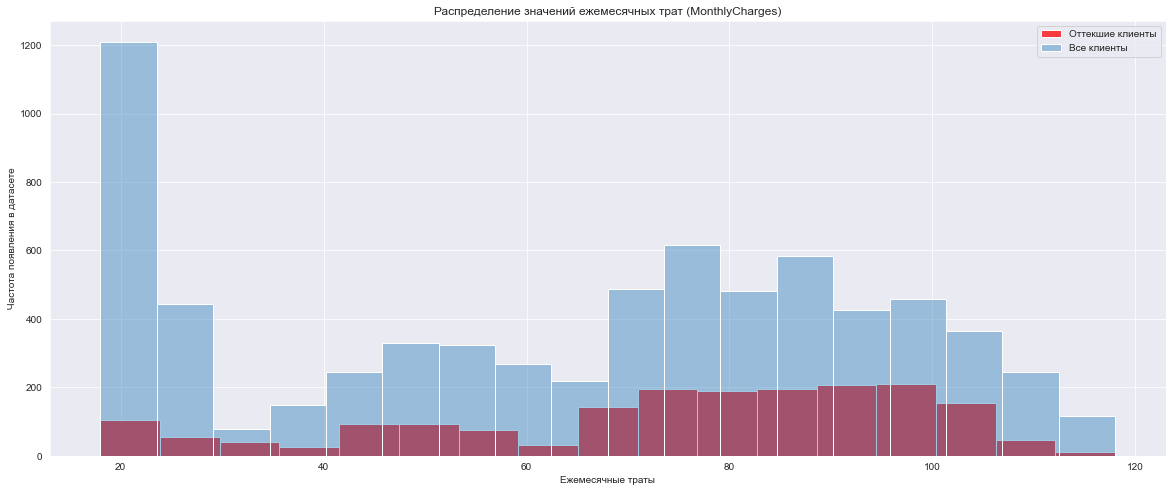

In [48]:
ax = sns.histplot(df_telecom.loc[df_telecom['escape_client'] == 1,'MonthlyCharges'], 
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df_telecom['MonthlyCharges'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений ежемесячных трат (MonthlyCharges)')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Частота появления в датасете');

Среди оттекших клиентов есть представители каждой из выделенной ранее групп. Примечательно, что оттекшие клиенты пользовались в основном дорогими тарифами.

Введем признак соответствующий длительности пользования клиентом услугами компании:

In [49]:
df_telecom['TotalTime'] = (df_telecom['EndDate'] - df_telecom['BeginDate']).dt.days

Посмотрим сколько времени ушедшие клиенты пользовались услугами компании:

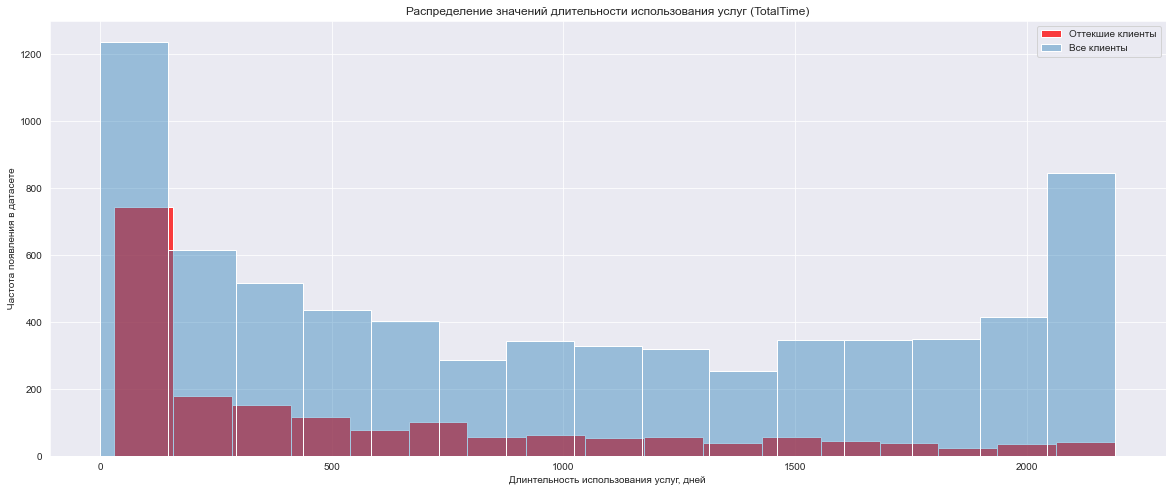

In [50]:
ax = sns.histplot(df_telecom.query('escape_client == 1')['TotalTime'],
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df_telecom['TotalTime'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений длительности использования услуг (TotalTime)')
plt.xlabel('Длинтельность использования услуг, дней')
plt.ylabel('Частота появления в датасете');

In [51]:
df_telecom.query('escape_client == 1')['TotalTime'].describe() 

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: TotalTime, dtype: float64

In [52]:
df_telecom['TotalTime'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: TotalTime, dtype: float64

Средняя длительность пользования услугами у оттекших клиентов практически в два раза меньше, чем у тех, которые остались. 

### Вывод

Все выделенные задачи для предобработки данных выполнены:

1. `BeginDate` – поле приведено к типу *datetime*;

2. `EndDate` – для значений "No" установлена "заглушка", соответствующая дате актуальности датасета - *2020-02-01*), после чего поле было приведено к формату *datetime*;

3. `MonthlyCharges` - поле приведено к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях);

4. `TotalCharges` - неявные пропуски (пустые значения) приведены в соответствие с полем суммарных трат, так как пропуски маркеруют клиентов, начавших пользоваться услагми компании в феврале 2020 года.

После чего все датафреймы были объединены.

Из статистических характеристик объедененного датафрейма можно выделить интересные особенности:

- практически две трети пользователей предпочитают безналичный расчет;

- среднее значение месячных трат практически совпадает с медианным значением, то есть имеет распределение с небольшим отрицательным смещением;

- **распределение значений суммарных трат наоборот, сильное положительное смещение - медиана практически на 40% меньше среднего. Возможно это связано с наличием нулей - неявных пропусков. Это нужно выяснить далее**;

- относительно демографии: 16% пенсионеров, 48% имеют супруга(у), у 29% клиентов имеются иждевенцы. Баланс классов гендера соблюдается;

- 34% пользователей продолжают использовать интернет соединение через через телефонную линию, 42% пользователей имеют возможность использовать вторую линию во время звонка; 

- По услугам данные приведены в таблице:

|Услуга| Доля пользователей услуги |  
|------|---------------------------|
|антивирус (DeviceProtection)| 34%|
|блокировка небезопасных сайтов (OnlineSecurity)| 29%|
|выделенная линия технической поддержки (TechSupport)| 29%|
|облачное хранилище файлов для резервного копирования данных (OnlineBackup)|34%|
|cтриминговое телевидение (StreamingTV)|38%|
|каталог фильмов (StreamingMovies)|39%|

По распределению значений месячных трат выделяются три основные группы клиентов:

- с месячными тратами со значениями 20-30;
- с месячными тратами со значениями 30-70;
- с месячными тратами со значениями 70-120.

Был выделен целевой признак, имеет место дисбаланс классов (74/26). На этапе подготовки данных для модели нужно решить эту проблему методом семплирования. Также можно использовать метрику устойчивую к дисбалансу классов (например *AUC-ROC*, *F1*);

Данные были поделены на три группы для исследования их различий. Оказалось, что клиенты третей группы больше пользуются услугами. Первая группа практически вообще не пользуется дополнительными услугами (доля не превшает 10%)

Также примечательно, что:

- доля пользователей, использующих безналичный расчет растет от 38% в первой группе, до 62% во второй группе, и до 76% в третьей группе;

- среди третьей группы больше пенсионеров (7% первая группа, 16% - вторая группа, 25% - третья группа);

- в третей группе больше клиентов, состоящих в браке (43% первая группа, 45% - вторая группа, 57% - третья группа);

- иждевенцев, наоборот, больше в первой группе - 36%, во второй группе 28%, в третьей 26%;

- среди третьей группы только 7% пользователей продолжают использовать интернет соединение через через телефонную линию, во второй группе это значение вырастает до 59%, в третьей 38%;

- отток клиентов самый большой в третьей группе - 34%, во второй группе 29%, в первой 16%.

Было исследовано распределение даты регистрации клиентов во времени: наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина вновь привлеченных клиентов стабильна. Далее с начала 2019 по начало 2020 года снова наблюдаем бурный рост количества новых клиентов.

На протяжении 4 месяцев подряд происходил равномерный отток клиентов (октябрь 2019 - январь 2020).

Среди оттекших клиентов есть представители каждой из выделенной ранее групп. Примечательно, что оттекшие клиенты пользовались в основном дорогими тарифами.

Средняя длительность пользования услугами у оттекших клиентов практически в два раза меньше, чем у тех, которые остались. 

Был сгенерирован признак - длительность использования услуг компании.

Дополнительных вопросов к данным на данном этапе не возникло.

## Подготовка данных для модели

Зафиксируем случайность для воспроизводимости результатов:

In [53]:
SEED = 80822

Удалим признаки с датой:

In [54]:
df_telecom = df_telecom.drop(['BeginDate', 'EndDate'], axis=1)

In [55]:
df_telecom.shape

(7043, 20)

Закодируем два оставшихся признака прямым кодированием. В данном случае это самый рациональный метод кодирования, так как пространство признаков не большое, и число признаков увеличится всего на 4.

In [56]:
df = pd.get_dummies(df_telecom, drop_first=True)

In [57]:
df.shape

(7043, 24)

Посмотрим на тепловую карту матрицы парных корреляций признаков:

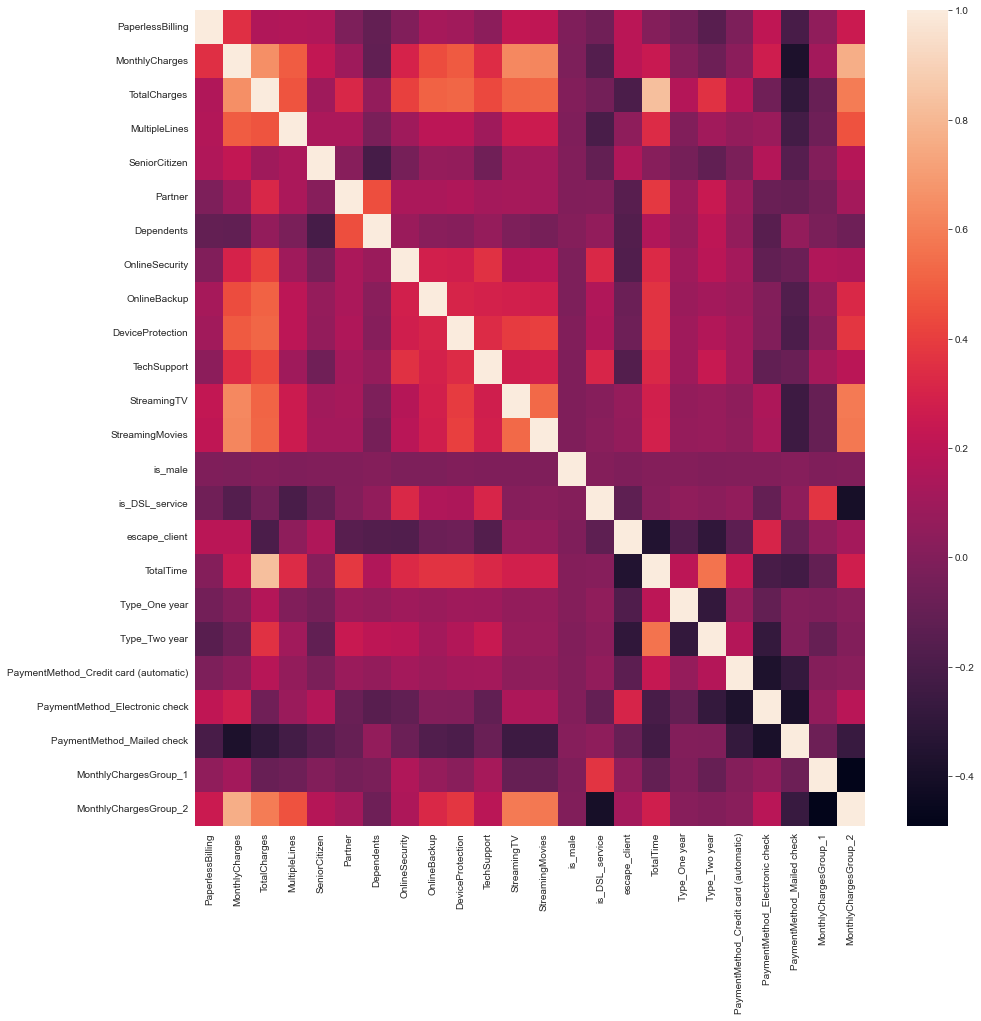

In [58]:
corrMatrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=False);

Сгенерированный признак длительности использования услуг компании очень сильно коррелирует с суммарными тратами (корреляции по бинарным признакам не оцениваем). Действительно, признаки дублируют друг друга по своей сути. Так как отношение ежемесячных трат и суммарных трат по сути и будет являтся длительностью использования услуг компании. Сделаем два варианта данных для моделей с ними и без них.

Остальные признаки имеют умеренную и слабую корреляцию. Посмотрим на коэффициент инфляции диспресии:

In [59]:
pd.Series([variance_inflation_factor(df.values, i)for i in range(df.shape[1])],index=df.columns)

PaperlessBilling                          2.939183
MonthlyCharges                           41.063204
TotalCharges                             17.341021
MultipleLines                             2.670912
SeniorCitizen                             1.371209
Partner                                   2.819411
Dependents                                1.959808
OnlineSecurity                            2.180569
OnlineBackup                              2.342027
DeviceProtection                          2.421458
TechSupport                               2.261035
StreamingTV                               3.223822
StreamingMovies                           3.262297
is_male                                   1.971995
is_DSL_service                            3.171590
escape_client                             1.884632
TotalTime                                15.598557
Type_One year                             1.974671
Type_Two year                             3.335466
PaymentMethod_Credit card (auto

Признаки соответствующие ежемесячным тратам, длительности использования услуг, и месячных трат по группам имееют очень большой коэффициент инфляции дисперсии. Можно попробовать построить модель с ними, и без них.

Запишем целевой признак:

In [60]:
target = df['escape_client']

И остальные признаки:

In [61]:
features = df.drop('escape_client', axis=1)

Произведем деление на обучающую и отложенную выборку (возьмем соотношение 4:1):

In [62]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=.8, 
                                                                            random_state=SEED,
                                                                            stratify=target)

In [63]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5634, 23), (5634,), (1409, 23), (1409,))

Как условились выше, сделаем признаки с `MonthlyCharges`, `TotalTime` и без (групповой признак трогать не будем, скорее всего хватит удаления только этих признаков):

In [64]:
features_train_vif = features_train.drop(['MonthlyCharges', 'TotalTime'] , axis=1)
features_test_vif = features_test.drop(['MonthlyCharges', 'TotalTime'], axis=1)

Проверим коэффициент инфляции дисперсии:

In [65]:
pd.Series([variance_inflation_factor(features_train_vif.values, i)for i in range(features_train_vif.shape[1])],
          index=features_train_vif.columns)

PaperlessBilling                         2.623520
TotalCharges                             7.723758
MultipleLines                            2.578945
SeniorCitizen                            1.344351
Partner                                  2.777447
Dependents                               1.973230
OnlineSecurity                           2.163290
OnlineBackup                             2.291654
DeviceProtection                         2.377747
TechSupport                              2.184163
StreamingTV                              3.177704
StreamingMovies                          3.210414
is_male                                  1.857837
is_DSL_service                           3.049946
Type_One year                            1.663897
Type_Two year                            2.352590
PaymentMethod_Credit card (automatic)    1.657214
PaymentMethod_Electronic check           2.248473
PaymentMethod_Mailed check               1.515370
MonthlyChargesGroup_1                    2.883686


Все коэффициенты в пределах допустимых значений.

In [66]:
features_train_vif.shape, target_train.shape, features_test_vif.shape, target_test.shape

((5634, 21), (5634,), (1409, 21), (1409,))

In [67]:
target_train.mean(), target_test.mean()

(0.2653532126375577, 0.2654364797728886)

Для борьбы с дисбалансом классов воспользуемся апсемплингом и подготовим третий вариант набора данных:

In [68]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=SEED)
    
    return features_upsampled, target_upsampled

In [69]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [70]:
target_upsampled.mean()

0.5200602968460112

Балансировку классов признаков без `MonthlyCharges` и `TotalTime` будем производить встроенными в модели методами. Данные готовы для моделирования.

## Разработка и отбор лучшей модели

Функция обучения моделей:

In [71]:
# Функция обучения моделей с параметрами по умолчанию.
# Аргументы: класс модели, обучающая выборка и (необязательно) режим использования сбалансированной развесовки классов.
# Возвращает метрики на 5-х кратной кросс-валидации в формате Series.
def train (model, features, target, SEED, notation, balanced_weights=False):
    model_instance = None
    class_weights = None
    
    # CatBoost не имеет режима class_weight='balanced', для него веса зададим вручную:
    if balanced_weights == True:
        if model == CatBoostClassifier:
            class_weights = [1 - np.mean(target), np.mean(target)]
        else:
            class_weights = 'balanced'
    
    if model == LogisticRegression:
        model_instance = model(random_state=SEED, solver='lbfgs', max_iter=1000, class_weight=class_weights)
    elif model == RandomForestClassifier:
        model_instance = model(random_state=SEED, n_estimators=100, class_weight=class_weights)
    elif model == CatBoostClassifier:
        model_instance = model(random_state=SEED, verbose=0, class_weights=class_weights)
    else:
        model_instance = model(random_state=SEED, class_weight=class_weights)


    # Обучим модель:
    model_instance.fit(features, target)
        
    # Вычислим интересующие нас метрики:
    f1 = np.mean(cross_val_score(model_instance, features, target, cv=5, scoring=make_scorer(f1_score)))
    roc_auc = np.mean(cross_val_score(model_instance, features, target, cv=5, scoring=make_scorer(roc_auc_score)))
    
    stat = pd.Series([type(model_instance).__name__ + notation, f1, roc_auc], index=['Model', 'F1', 'ROC_AUC'])
    return stat, model_instance

Запишем список с классами моделей:

In [72]:
model_list = [LogisticRegression, RandomForestClassifier, CatBoostClassifier]

И создадим датафрейм со статистикой:

In [73]:
stats = pd.DataFrame({'Model':[], 'F1':[], 'ROC_AUC':[]})

Обучим модели на всех признаках (*raw*):

In [74]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train, target_train, SEED, '_raw')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.16s/it]


In [75]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.578345,0.709911
1,RandomForestClassifier_raw,0.589273,0.71594
2,CatBoostClassifier_raw,0.676685,0.76861


Лучшей моделью является `CatBoostClassifier`, как по *F1*-мере, так и по *roc_auc* (0.67 и 0.77 на обучающей выборке с 5-х кратной кросс валидацией соответственно). Запишем ее для тестирования в следующем разделе:

In [84]:
best_model_raw = model_instances[2]

Проделаем то же самое, но с балансировкой классов:

In [77]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train, target_train, SEED, '_raw_balanced', balanced_weights=True)
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.14s/it]


In [78]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.578345,0.709911
1,RandomForestClassifier_raw,0.589273,0.71594
2,CatBoostClassifier_raw,0.676685,0.76861
3,LogisticRegression_raw_balanced,0.619751,0.7588
4,RandomForestClassifier_raw_balanced,0.588846,0.715226
5,CatBoostClassifier_raw_balanced,0.541532,0.68676


Показатели регрессионной модели увеличились, но незначительно.У случайного леса показатели не изменились, а у кетбуста показатели снизились.

Обучим модели на признаках скорректированных с помощью коэффициента инфляции дисперссии (без `MonthlyCharges` и `TotalTime`):

In [79]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train_vif, target_train, SEED, '_vif')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.01s/it]


In [80]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.578345,0.709911
1,RandomForestClassifier_raw,0.589273,0.71594
2,CatBoostClassifier_raw,0.676685,0.76861
3,LogisticRegression_raw_balanced,0.619751,0.7588
4,RandomForestClassifier_raw_balanced,0.588846,0.715226
5,CatBoostClassifier_raw_balanced,0.541532,0.68676
6,LogisticRegression_vif,0.535979,0.683787
7,RandomForestClassifier_vif,0.537063,0.684741
8,CatBoostClassifier_vif,0.568408,0.703851


Показатели *F1*-меры и *roc_auc* снизились. Балансировку классов делать не будем.

Обучим модели на признаках с апсемплингом:

In [81]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_upsampled, target_upsampled, SEED, '_upsampling')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.68s/it]


In [82]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.578345,0.709911
1,RandomForestClassifier_raw,0.589273,0.71594
2,CatBoostClassifier_raw,0.676685,0.76861
3,LogisticRegression_raw_balanced,0.619751,0.7588
4,RandomForestClassifier_raw_balanced,0.588846,0.715226
5,CatBoostClassifier_raw_balanced,0.541532,0.68676
6,LogisticRegression_vif,0.535979,0.683787
7,RandomForestClassifier_vif,0.537063,0.684741
8,CatBoostClassifier_vif,0.568408,0.703851
9,LogisticRegression_upsampling,0.780695,0.75986


Качество моделей с апсемплингом существенно вырасло. Лучшей моделью является `RandomForestClassifier`. Модель случайного леса с апсемплингом увеличила *F1*-меру с 0.59 до 0.92, а *roc_auc* c 0.72 до 0.90 (показатели `CatBoostClassifier` со всеми признаками). Запишем лучшую модель и сравним ее на тестировании с моделью кетбуст на полных данных:

In [85]:
best_model_upsampling = model_instances[1]

## Тестирование

Напишем функцию-тест:

In [87]:
def testing_model(features_test, target_test, model):
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)[:,1]
    fpr, tpr, threshold = roc_curve(target_test, probabilities_test)
    
    f1 = f1_score(target_test, predictions_test)
    roc_auc = roc_auc_score(target_test, probabilities_test)
    
    print('Класс модели: ', type(model).__name__)
    print('F1-мера: ', f1)
    print('roc-auc: ', roc_auc)
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test, pos_label=1)
    plt.plot(fpr, tpr, label=type(model).__name__)
    plt.xlabel('Вероятность ошибки 1-рода')
    plt.ylabel('Recall')
    plt.title('ROC-кривая модели класса ' + type(model).__name__)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend();
    
    cmatrix = confusion_matrix(target_test, predictions_test)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
    plt.show();

Протестируем лучшую модель на полных данных (*raw*):

Класс модели:  CatBoostClassifier
F1-мера:  0.7158145065398336
roc-auc:  0.9179635226949805


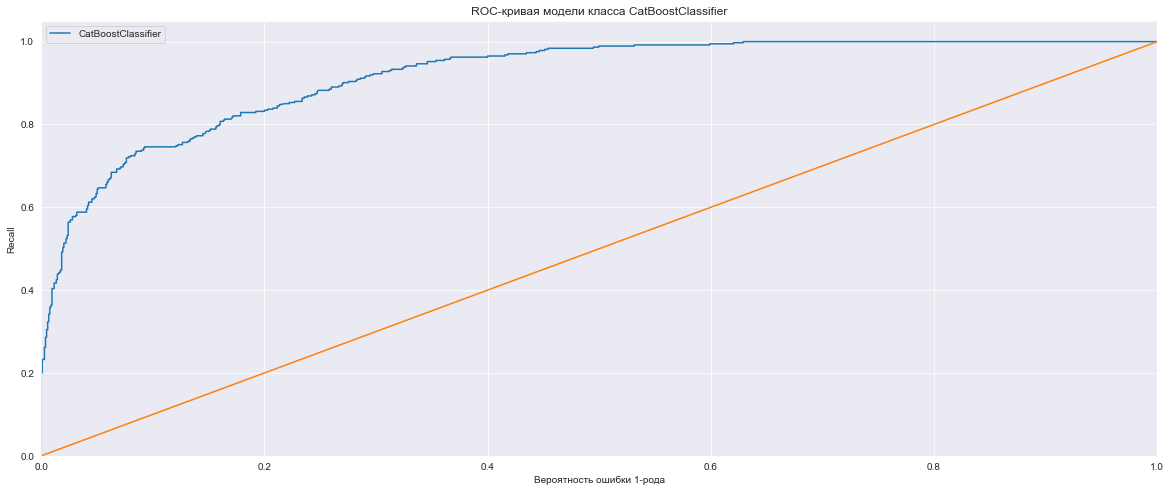

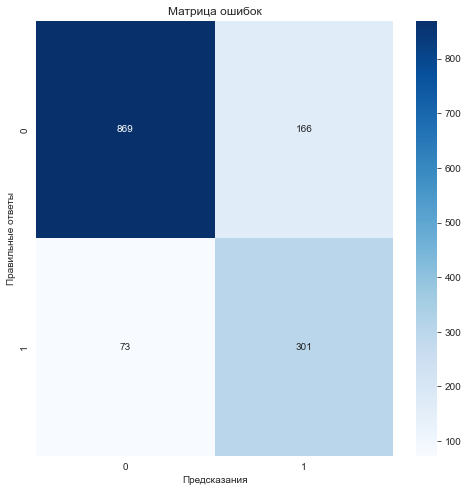

In [88]:
testing_model(features_test, target_test, best_model_raw)

Отличные показатели.

Лучшая модель на данных с апсемплингом (случайный лес):

Класс модели:  RandomForestClassifier
F1-мера:  0.6248366013071895
roc-auc:  0.8464103955152549


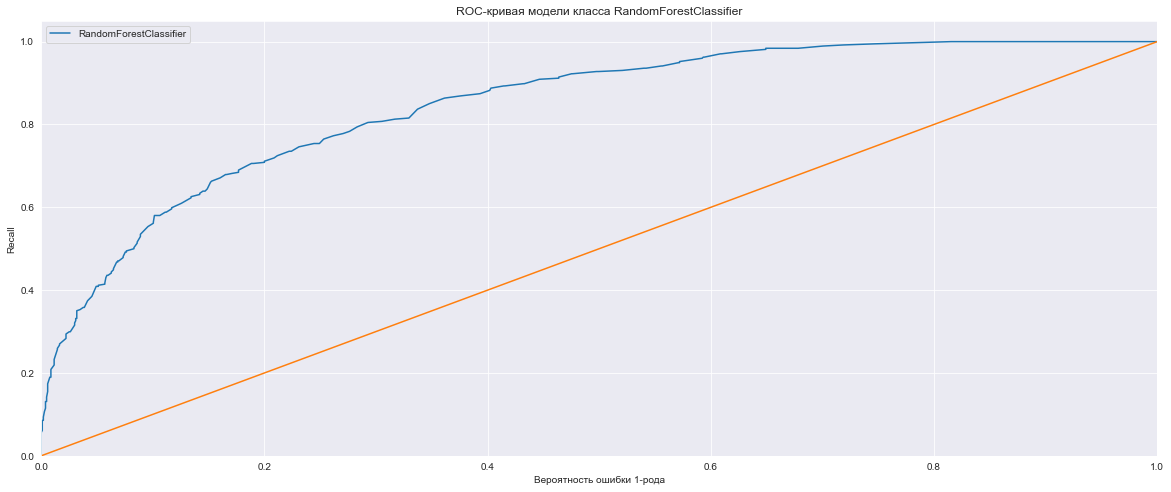

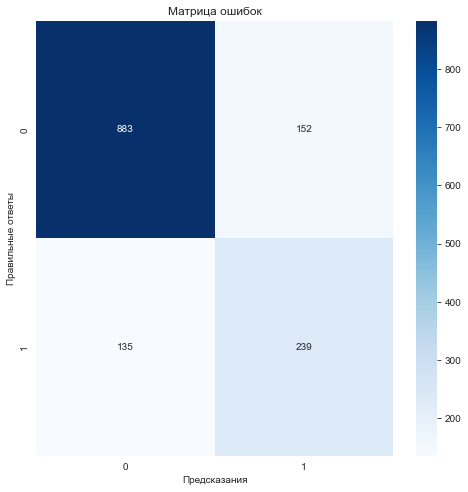

In [89]:
testing_model(features_test, target_test, best_model_upsampling)

Показатели на тесте оставляют желать лучшего. Лучшей моделью оказалась модель класса `CatBoostClassifier` на полных данных. 
Показатели: 
- *F1*-мера 0.72;
- *roc-auc* 0.92.

In [90]:
best_model = best_model_raw

## Анализ важности признаков модели

In [95]:
train_dataset = Pool(features_train, target_train)

In [99]:
feature_importance = best_model.get_feature_importance(train_dataset, prettified = True)

In [108]:
feature_importance

,Feature Id,Importances
0,TotalTime,41.731800
1,MonthlyCharges,12.280037
2,TotalCharges,10.517825
3,Type_Two year,5.428539
4,Type_One year,3.252445
5,is_male,2.566081
6,PaymentMethod_Electronic check,2.561356
7,is_DSL_service,2.143827
8,OnlineSecurity,1.986265
9,TechSupport,1.756698


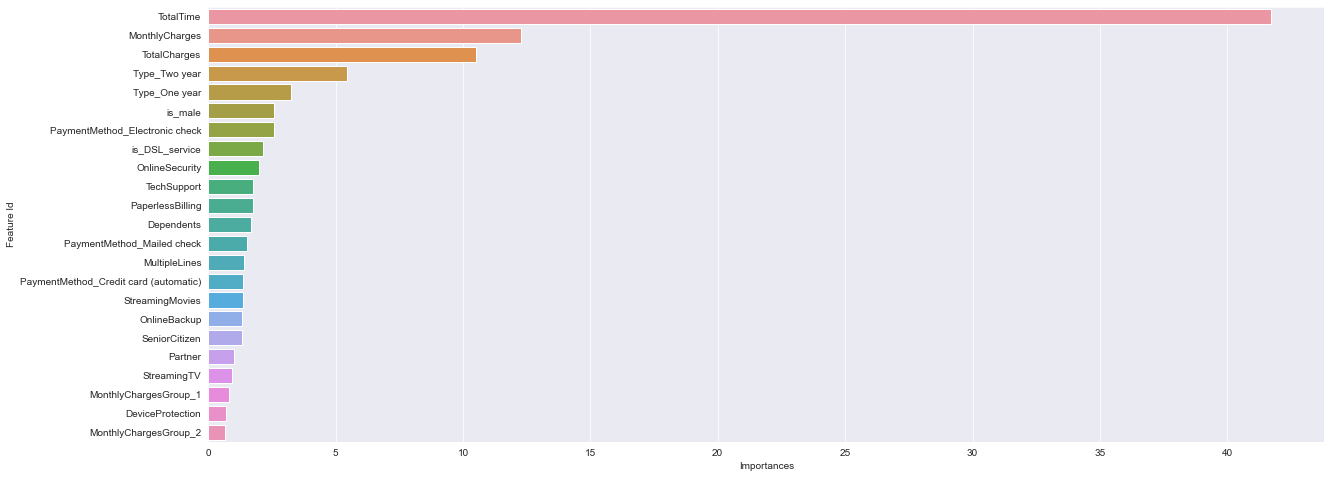

In [107]:
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Достаточно логично, что на лояльность клиентов виляет время использования услуг. Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Второй и третий признак - месячные траты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.

## Общий вывод

При выполнении работы были загружены и рассмотрены таблицы с данными: 

- `df_contract`;  
- `df_internet`;
- `df_personal`;
- `df_phone`.

**I. Исследовательская часть**

Всего в выборке представлены договоры с 7043 клиентами, из которых пользователей интернета - 5517, пользователей телефона - 6361. Явные пропуски и дубликаты не найдены.

В процессе были решены проблемы для предобработки данных:

1. `BeginDate` – поле приведено к типу *datetime*;

2. `EndDate` – для значений "No" установлена "заглушка", соответствующая дате актуальности датасета - *2020-02-01*), после чего поле было приведено к формату *datetime*;

3. `MonthlyCharges` - поле приведено к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях);

4. `TotalCharges` - неявные пропуски (пустые значения) приведены в соответствие с полем суммарных трат, так как пропуски маркеруют клиентов, начавших пользоваться услагми компании в феврале 2020 года.

После чего все датафреймы были объединены.

Из статистических характеристик объедененного датафрейма можно выделить интересные особенности:

- практически две трети пользователей предпочитают безналичный расчет;

- среднее значение месячных трат практически совпадает с медианным значением, то есть имеет распределение с небольшим отрицательным смещением;

- **распределение значений суммарных трат наоборот, сильное положительное смещение - медиана практически на 40% меньше среднего. Возможно это связано с наличием нулей - неявных пропусков. Это нужно выяснить далее**;

- относительно демографии: 16% пенсионеров, 48% имеют супруга(у), у 29% клиентов имеются иждевенцы. Баланс классов гендера соблюдается;

- 34% пользователей продолжают использовать интернет соединение через через телефонную линию, 42% пользователей имеют возможность использовать вторую линию во время звонка; 

- По услугам данные приведены в таблице:

|Услуга| Доля пользователей услуги |  
|------|---------------------------|
|антивирус (DeviceProtection)| 34%|
|блокировка небезопасных сайтов (OnlineSecurity)| 29%|
|выделенная линия технической поддержки (TechSupport)| 29%|
|облачное хранилище файлов для резервного копирования данных (OnlineBackup)|34%|
|cтриминговое телевидение (StreamingTV)|38%|
|каталог фильмов (StreamingMovies)|39%|

По распределению значений месячных трат выделяются три основные группы клиентов:

- с месячными тратами со значениями 20-30;
- с месячными тратами со значениями 30-70;
- с месячными тратами со значениями 70-120.

Был выделен целевой признак, имеет место дисбаланс классов (74/26). На этапе подготовки данных для модели нужно решить эту проблему методом семплирования. Также можно использовать метрику устойчивую к дисбалансу классов (например *AUC-ROC*, *F1*);

Данные были поделены на три группы для исследования их различий. Оказалось, что клиенты третей группы больше пользуются услугами. Первая группа практически вообще не пользуется дополнительными услугами (доля не превшает 10%). Данный признак был использован при моделировании. Также был сгенерирован дополнительный признак - длительность использования услуг компании.

Примечательно, что:

- доля пользователей, использующих безналичный расчет растет от 38% в первой группе, до 62% во второй группе, и до 76% в третьей группе;

- среди третьей группы больше пенсионеров (7% первая группа, 16% - вторая группа, 25% - третья группа);

- в третей группе больше клиентов, состоящих в браке (43% первая группа, 45% - вторая группа, 57% - третья группа);

- иждевенцев, наоборот, больше в первой группе - 36%, во второй группе 28%, в третьей 26%;

- среди третьей группы только 7% пользователей продолжают использовать интернет соединение через через телефонную линию, во второй группе это значение вырастает до 59%, в третьей 38%;

- отток клиентов самый большой в третьей группе - 34%, во второй группе 29%, в первой 16%.

Было исследовано распределение даты регистрации клиентов во времени: наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина вновь привлеченных клиентов стабильна. Далее с начала 2019 по начало 2020 года снова наблюдаем бурный рост количества новых клиентов.

На протяжении 4 месяцев подряд происходил равномерный отток клиентов (октябрь 2019 - январь 2020).

Среди оттекших клиентов есть представители каждой из выделенной ранее групп. Примечательно, что оттекшие клиенты пользовались в основном дорогими тарифами.

Средняя длительность пользования услугами у оттекших клиентов практически в два раза меньше, чем у тех, которые остались. 


**II. Модельная часть**

В качестве подготовки к моделированию из исходных данных было подготовлено три набора данных для моделей:

1. "Сырой" (*raw*) вариант с полным количеством признаков.

2. Признаки, отобранные на основании коэффициента инфляции диспресии (*VIF - variance inflation factor*). На этом этапе было отброшено два признака с достаточно большими коэффициентами инфляции дисперсии - `MonthlyCharges` и `TotalTime`.

3. Данные с апсемплингом для борьбы с дисбалансом классов (*на "сырых" данных применялась встроенная балансировка классов для моделей, однако, она увеличила метрики только регрессионной модели*).

Метрики всех построенных моделей представлены в таблице:

|Класс модели; примечание |	*F1* |	*roc-auc*|
|--------------------|-------|-----------|
|LogisticRegression; "сырые" данные|0.578|0.710|
|RandomForestClassifier; "сырые" данные|0.589|0.72|
|**CatBoostClassifier; "сырые" данные**|**0.68**|**0.77**|
|LogisticRegression; "сырые" данные с балансировкой|0.62|0.76|
|RandomForestClassifier; "сырые" данные с балансировкой|0.59|0.71|
|CatBoostClassifier; "сырые" данные с балансировкой|0.54|0.69|
|LogisticRegression; данные, отобранные на основе *VIF*|0.54|0.68|
|RandomForestClassifier; данные, отобранные на основе *VIF*|0.54|0.68|
|CatBoostClassifier; данные, отобранные на основе *VIF*|0.57|0.70|
|LogisticRegression; данные с апсемплингом|0.78|0.76|
|**RandomForestClassifier; данные с апсемплингом**|**0.92**|**0.91**|
|CatBoostClassifier; данные с апсемплингом|0.88|0.87|

Как уже упоминалось выше, балансировка классов не привела к существенному увеличению метрик, как и с данными, отобранными на основе *VIF* - поэтому на этих этапах лучшая модель не отбиралась. 

Качество моделей с апсемплингом существенно вырасло. Лучшим классом модели являлась `RandomForestClassifier`. Модель случайного леса с апсемплингом увеличила *F1*-меру с 0.59 до 0.92, а *roc_auc* c 0.72 до 0.90 (показатели `CatBoostClassifier` со всеми признаками). Запишем лучшую модель с апсемплингом сравнили на отложенной выборке с моделью кетбуст на полных данных (*raw*).

На отложенной выборке выиграла модель класса `CatBoostClassifier` на полных данных. 

ЕЕ показатели: 

- *F1*-мера 0.72 (против 0.62 у `RandomForestClassifier`);
- *roc-auc* 0.92 (против 0.85 у `RandomForestClassifier`).

**III. Анализ важности признаков модели**

Топ-10 признаков, оказывающих на модель наибольшее влияние:

|Имя признака|Расшифровка|Важность для модели, %|
|------------|-----------|----------------------|
|TotalTime|	Длительность использования услуг компании| 41.73
|MonthlyCharges|Ежемесячные траты|	12.28
|TotalCharges|Суммарные траты|	10.52
|Type_Two year|Договор заключен на два года (бинарная переменная)|	5.43
|Type_One year|Договор заключен на год (бинарная переменная)|	3.25
|is_male|Клиент мужчина (бинарная переменная)|	2.57
|PaymentMethod_Electronic check|Способ оплаты - электронный чек (бинарная переменная)|	2.56
|is_DSL_service|Интернет соединение через телефонную линию (бинарная переменная)|	2.14
|OnlineSecurity|Подключена услуга блокировки небезопасных сайтов (бинарная переменная)|	1.99
|TechSupport|Подключена услуга технической поддержки (бинарная переменная)|	1.76

Достаточно логично, что на лояльность клиентов виляет время использования услуг. Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Второй и третий признак - месячные траты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.